In [1]:
import torch
from torch import nn
from torch import optim
from torchvision import datasets, utils
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt

import numpy as np
import pdb

In [2]:
model1 = nn.Sequential(
    nn.Linear(28 * 28, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
)

In [3]:
class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(28 * 28, 64)
        self.l2 = nn.Linear(64, 64)
        self.l3 = nn.Linear(64, 10)
        self.do = nn.Dropout(0.1)
        self.flat_input = True

    def forward(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        #drop = self.do(h1 + h2)
        logits = self.l3(h2)
        return logits

model2 = ResNet()

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.flat_input = False

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        #x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        #x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        #return F.softmax(x)
        return x

model = Net()

In [5]:
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.7)

In [6]:
criterion = nn.CrossEntropyLoss()

In [7]:
transform1 = transforms.Compose(
    [#transforms.RandomAffine(degrees=60, translate=(0.2, 0.2), scale=(0.5, 2.),
     #                                          shear=None, resample=0, fillcolor=0),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5,), (0.5,))])

transform2 = transforms.Compose(
    [transforms.RandomAffine(degrees=60, translate=(0.2, 0.2), scale=(0.5, 2.),
                                               shear=None, resample=0, fillcolor=0),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5,), (0.5,))])

batch_size = 16

train_data = datasets.MNIST(root='./data-mnist', train=True,
                                        download=False, transform=transform2)
#train, val = random_split(train_data, [55000, 5000])

val_data = datasets.MNIST(root='./data-mnist', train=False,
                                       download=False, transform=transform2)


train_loader = DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

val_loader = DataLoader(val_data, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

In [8]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

In [9]:
def init_weights(m):
    if type(m) == nn.Linear:
        print('Applying weights')
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)


In [10]:
nb_epochs = 4
model.apply(init_weights)
for epoch in range(nb_epochs):
    losses = list()
    running_loss = 0.0
    model.train()
    for i, batch in enumerate(train_loader, 0):
        x, y = batch

        if model.flat_input:
            b = x.size(0)
            x = x.view(b, -1)

        # 1 forward (get the "logits", output of the nn
        l = model(x)
        # 2 compute objective function
        J = criterion(l, y)

        #pdb.set_trace()
        # 3 cleaning the gradients
        # params.grad._xero()
        model.zero_grad()

        # 4 accumulate the partial derivatives of J wrt params
        # same as params.grad.add_(dJ/dparams)
        J.backward()

        # 5 step in the opposite direction of the gradient
        # same as -> with torch.no_grad(): params = params - eta * params.grad
        optimizer.step()

        losses.append(J.item())

        running_loss += J.item()
        if i % 1000 == 999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    print(f'Epoch {epoch + 1}, train loss:  {torch.tensor(losses).mean():.3f}')

    losses = list()
    model.eval()
    for batch in val_loader:
        x, y = batch

        if model.flat_input:
            b = x.size(0)
            x = x.view(b, -1)

        # 1 forward (get the "logits", output of the nn
        # Evaluation without creating gradient
        with torch.no_grad():
            l = model(x)

        # 2 compute objective function
        # Without gradient, this J is just a tensor (no grad connected to it)
        J = criterion(l, y)

        losses.append(J.item())

    print(f'Epoch {epoch + 1}, val loss:  {torch.tensor(losses).mean():.3f}')

Applying weights
Applying weights
[1,  1000] loss: 0.975
[1,  2000] loss: 0.672
[1,  3000] loss: 0.533
Epoch 1, train loss:  1.350
Epoch 1, val loss:  0.892
[2,  1000] loss: 0.419
[2,  2000] loss: 0.389
[2,  3000] loss: 0.358
Epoch 2, train loss:  0.759
Epoch 2, val loss:  0.645
[3,  1000] loss: 0.326
[3,  2000] loss: 0.315
[3,  3000] loss: 0.309
Epoch 3, train loss:  0.622
Epoch 3, val loss:  0.572
[4,  1000] loss: 0.295
[4,  2000] loss: 0.285
[4,  3000] loss: 0.278
Epoch 4, train loss:  0.566
Epoch 4, val loss:  0.490


c:\users\alejanpi\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  after removing the cwd from sys.path.


In [11]:
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)


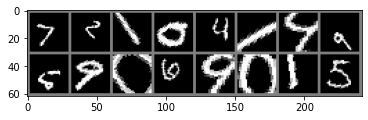

GroundTruth:      7     2     1     0     4     1     4     9     5     9     0     6     9     0     1     5
Predicted:      7     2     1     0     4     1     4     9     4     9     0     6     9     0     1     5


In [12]:
dataiter = iter(val_loader)
images, labels = dataiter.next()

#model = Net()
#model.load_state_dict(torch.load(PATH))
#outputs = model(images)

# print images
imshow(utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))
x = images
if model.flat_input:
    x = images.view(images.size(0), -1)
outputs = model(x)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(batch_size)))

In [13]:
correct = 0
total = 0
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        x = images
        if model.flat_input:
            x = images.view(images.size(0), -1)
        outputs = model(x)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 84 %


In [14]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        x = images
        if model.flat_input:
            x = images.view(images.size(0), -1)
        outputs = model(x)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 88 %
Accuracy of     1 : 98 %
Accuracy of     2 : 81 %
Accuracy of     3 : 77 %
Accuracy of     4 : 83 %
Accuracy of     5 : 72 %
Accuracy of     6 : 86 %
Accuracy of     7 : 78 %
Accuracy of     8 : 81 %
Accuracy of     9 : 80 %
